# Watch a temperature : scan temperature *v* time

From *2021-03 APS Python Training for Bluesky Data Acquisition*.

**Objective**

Measure the temperature for a short period and compute basics measures of the collected readings.

## Start the `instrument` package

In [1]:
from instrument.collection import *

I Fri-12:23:33 - ############################################################ startup
I Fri-12:23:33 - logging started
I Fri-12:23:33 - logging level = 10
I Fri-12:23:33 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/collection.py
I Fri-12:23:33 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/mpl/notebook.py
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/.logs/ipython_console.log
Mode           : rotate
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
I Fri-12:23:34 - #### Bluesky Framework ####
I Fri-12:23:34 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_python.py
I Fri-12:23:34 - /home/prjemian/Documents/projects/BCDA-APS/bluesky_instrument_training/instrument/framework/check_bluesky.py
I Fri-12:23:34 - /ho

## Describe

Note the initial settings of the `temperature` (controller).  It's actually an EPICS *swait* record that simulates a temperature sensor and controller.  It has a setpoint, a readback, and a few other support attributes as shown.  A Random noise level is part of the simulation.  We'll compute that noise level from the standard deviation of the measurements.

In [2]:
listdevice(temperature)

============================= =================================== ==========================
name                          value                               timestamp                 
============================= =================================== ==========================
temperature_setpoint          25.0                                2021-02-26 12:23:38.737681
temperature_readback          25.0                                2021-02-26 12:23:38.739024
temperature_done              True                                2021-02-26 12:23:38.740286
temperature_calculation       A+max(-D,min(D,(B-A)))+C*(RNDM-0.5) 2021-02-26 12:23:38.741236
temperature_description       temperature                         2021-02-26 12:23:38.737301
temperature_max_change        2.0                                 2021-02-26 12:23:38.739571
temperature_noise             1.0                                 2021-02-26 12:23:38.739024
temperature_previous_value_pv gp:userCalc8.VAL                    2021

## Count
Use the bluesky RunEngine, `RE`, and a standard plan, `bp.count()`, to count the temperature.

In [3]:
RE(bp.count([temperature]))



Transient Scan ID: 54     Time: 2021-02-26 12:23:38
Persistent Unique Scan ID: 'b322f081-ba4f-42c2-a2db-f85dd031eff7'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 12:23:39.2 |             25.41369 |
+-----------+------------+----------------------+
generator count ['b322f081'] (scan num: 54)


('b322f081-ba4f-42c2-a2db-f85dd031eff7',)

Take ten readings by adding the `num=10` keyword argument (a.k.a. *kwarg*).



Transient Scan ID: 55     Time: 2021-02-26 12:23:39
Persistent Unique Scan ID: 'f0b4614a-9508-406d-955e-be4f5410f1db'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 12:23:39.8 |             25.41369 |
|         2 | 12:23:39.9 |             25.41369 |
|         3 | 12:23:39.9 |             25.41369 |
|         4 | 12:23:40.0 |             25.41369 |
|         5 | 12:23:40.0 |             25.41369 |
|         6 | 12:23:40.0 |             25.41369 |
|         7 | 12:23:40.1 |             25.41369 |
|         8 | 12:23:40.1 |             25.41369 |
|         9 | 12:23:40.1 |             25.41369 |
|        10 | 12:23:40.1 |             25.41369 |
+-----------+------------+----------------------+
generator count ['f0b4614a'] (scan num: 55)


('f0b4614a-9508-406d-955e-be4f5410f1db',)

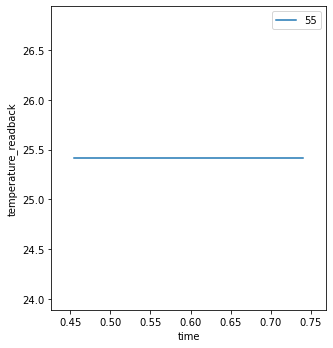

In [4]:
RE(bp.count([temperature], num=10))

Do all the readings look the same?  Perhaps there are only two different values (first one, then the other)?  That's because our measurements were only *reading* the temperature without waiting for it to update.  (If there are two different values, we caught the moment when EPICS updated the calculation.)  The table above showed `temperature_scanning_rate 5` which means EPICS is only updating every 2 seconds.

In [5]:
temperature.scanning_rate.get(as_string=True)

'2 second'

## Adjust the measurement interval
We need to slow down the measurement to this interval by adding the `delay=2` kwarg, sampling every 2 seconds.



Transient Scan ID: 56     Time: 2021-02-26 12:23:40
Persistent Unique Scan ID: '550ba458-d43a-4304-b211-91f207f6ca44'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 12:23:40.9 |             25.41369 |
|         2 | 12:23:42.8 |             24.89149 |
|         3 | 12:23:44.8 |             24.65364 |
|         4 | 12:23:46.8 |             24.72190 |
|         5 | 12:23:48.8 |             24.69121 |
|         6 | 12:23:50.8 |             25.35872 |
|         7 | 12:23:52.8 |             24.89944 |
|         8 | 12:23:54.8 |             25.15153 |
|         9 | 12:23:56.8 |             25.32324 |
|        10 | 12:23:58.8 |             25.18434 |
+-----------+------------+----------------------+
generator count ['550ba458'] (scan num: 56)


('550ba458-d43a-4304-b211-91f207f6ca44',)

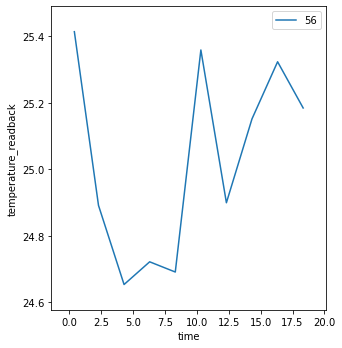

In [6]:
RE(bp.count([temperature], num=10, delay=2))

Let's reduce the update interval that EPICS uses, to the shortest interval EPICS provides, so our measurements do not take so long.

In [7]:
# print the list of possible values
print(temperature.scanning_rate.enum_strs)

# set the shortest interval, by name
temperature.scanning_rate.put(".1 second")
temperature.scanning_rate.get(as_string=True)

('Passive', 'Event', 'I/O Intr', '10 second', '5 second', '2 second', '1 second', '.5 second', '.2 second', '.1 second')


'.1 second'

## Collect our measurements
Repeat the measurement, this time with more observations.

Also, we'll add a metadata key:value pair so that later we can find this data more easily in the database.  Most plans take a `md={}` kwarg where the value is a Python dictionary with the key:value pair(s) to add to the run's metadata.



Transient Scan ID: 57     Time: 2021-02-26 12:24:01
Persistent Unique Scan ID: 'a748a3ac-3eea-4dde-a78f-0bf79fcf966f'
New stream: 'baseline'
New stream: 'primary'
+-----------+------------+----------------------+
|   seq_num |       time | temperature_readback |
+-----------+------------+----------------------+
|         1 | 12:24:01.6 |             24.60661 |
|         2 | 12:24:01.6 |             25.13038 |
|         3 | 12:24:01.7 |             25.05129 |
|         4 | 12:24:01.8 |             24.81199 |
|         5 | 12:24:01.9 |             25.22773 |
|         6 | 12:24:02.1 |             25.29049 |
|         7 | 12:24:02.1 |             24.73816 |
|         8 | 12:24:02.2 |             24.79042 |
|         9 | 12:24:02.4 |             24.90708 |
|        10 | 12:24:02.5 |             24.73680 |
|        11 | 12:24:02.6 |             24.70856 |
|        12 | 12:24:02.7 |             25.41049 |
|        13 | 12:24:02.8 |             25.45317 |
|        14 | 12:24:02.9 |         

('a748a3ac-3eea-4dde-a78f-0bf79fcf966f',)

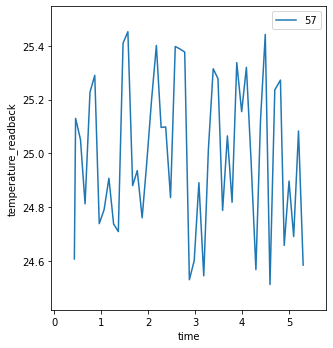

In [8]:
RE(bp.count([temperature], num=50, delay=0.1, md={"motive": "tscan"}))

## Get the data (from the database)
Let's get the measured data from the database now.  It's the most recent bluesky run, so an index of `-1` will identify it.

In [9]:
dataset = db.v2[-1].primary.read()

Let's get the values as a 1-D numpy array.

In [10]:
T = dataset["temperature_readback"].values

## Compute the statistics
Use the methods of numpy arrays to compute maximum, mean, standard deviation, and minimum.  Looks nicer in a table.

In [11]:
table = pyRestTable.Table()
table.addLabel("measure")
table.addLabel("value")
table.addRow(("max", T.max()))
table.addRow(("mean", T.mean()))
table.addRow(("dev", T.std()))
table.addRow(("min", T.min()))
table.addRow(("#", len(T)))
print(table)

======= ===================
measure value              
======= ===================
max     25.45317006179904  
mean    24.99790310521096  
dev     0.28447620581586675
min     24.511444266422522 
#       50                 
======= ===================



Let's replot that data for comparison.

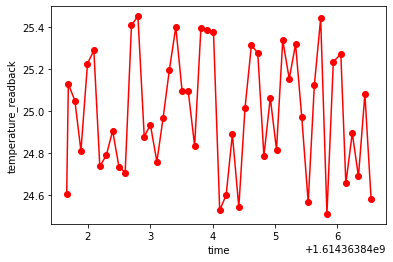

In [12]:
dataset["temperature_readback"].plot(marker="o", color="red")